# Unsupervised Image Segmentation

In [270]:
import numpy as np
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
import datetime
import json

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from skimage.segmentation import slic
from skimage.future import graph

import torch
import torchvision

import wnet_src.wnet as wnet
import wnet_src.wnet as wnet
import wnet_src.network as network
import wnet_src.loss as loss
from wnet_src.crf import crf_fit_predict, crf_batch_fit_predict

import evaluation
import importlib
importlib.reload(evaluation)

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

## Utility functions

In [302]:
# Creates an RGB representation of a segmentation mask using the mean color of each cluster
def mask_to_rgb(mask, image):
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    for i in range(0, mask.max().astype(int)+1):
        color = image[mask==i].mean(0)
        mask_rgb[mask==i] = color
    return np.round(mask_rgb).astype(np.uint8)

# Saves segmentation mask as RGB image and CSV
def save_segmentation(mask, image, method_name, id):
    png_path = os.path.join("output", method_name, "png", id + ".png")
    csv_path = os.path.join("output", method_name, "csv", id + ".csv")
    os.makedirs(os.path.dirname(png_path), exist_ok=True)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    mask_rgb = mask_to_rgb(mask, image)
    mask_rgb = Image.fromarray(mask_rgb)
    mask_rgb.save(png_path)
    np.savetxt(csv_path, mask, delimiter=',')

def ensemble_bagging(segmentations):
    segmentations_categorical = []
    for segmentation in segmentations:
        segmentation = np.array(segmentation)
        segmentation_categorical = np.zeros(segmentation.shape[0:2])
        colors = np.unique(segmentation.reshape(-1, segmentation.shape[2]), axis=0)
        for i, color in enumerate(colors):
            segmentation_categorical[(segmentation == color).all(axis=2)] = i
        segmentations_categorical.append(segmentation_categorical)

    stack = np.dstack(segmentations_categorical)
    hyper_colors = np.unique(stack.reshape(-1, stack.shape[2]), axis=0)
    hyper_image = np.zeros(stack.shape[0:2])
    for i, color in enumerate(hyper_colors):
        hyper_image[(stack == color).all(axis=2)] = i
    hyper_image = hyper_image.astype(int)
    return hyper_image

def ensemble_stacking(base_segmentation):
    base_segmentation = np.array(base_segmentation)
    labels = slic(base_segmentation, compactness=30, n_segments=400, )
    g = graph.rag_mean_color(base_segmentation, labels, mode='similarity')
    label_sets = []
    for i in range(5):
        label_sets.append(mask_to_rgb(graph.cut_normalized(labels, g, random_state=i), base_segmentation))
    labels = ensemble_bagging(label_sets)
    return labels

def compare_segmentations(segmentations):
    n_rows = len(segmentations) // 3 + (1 if len(segmentations) % 3 > 0 else 0)
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(5, 5))
    for i, key in enumerate(segmentations):
        axes[i // 3, i % 3].imshow(segmentations[key])
        axes[i // 3, i % 3].axis('off')
        axes[i // 3, i % 3].set_title(key)
        axes[i // 3, i % 3].set(xticks=[], yticks=[])
    # loop through unfilled axes and remove them
    for i in range(len(segmentations), n_rows * 3):
        fig.delaxes(axes[i // 3, i % 3])
        
    fig.tight_layout()
    plt.show()
    plt.close()

def plot_scores(methods, scores_, title, score_names, ylabel, colors, higher_better=True, target_ax=None):
    methods = list(methods)
    scores = []
    for method in methods:
        scores.append(scores_[method][ylabel])
    scores = np.array(scores)
    x = np.arange(len(methods))
    width = 0.35
    ax = target_ax if target_ax else plt.subplots()[1]
    rects1 = ax.bar(x - width/2, scores[:,0], width, label=score_names[0], color=colors[0])
    rects2 = ax.bar(x + width/2, scores[:,1], width, label=score_names[1], color=colors[1])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    best_index = np.argmax(scores[:,0]) if higher_better else np.argmin(scores[:,0])
    methods[best_index] = r'$\mathbf{' + methods[best_index] + r'}$'
    ax.set_xticks(x, methods)
    ax.legend()
    return ax

def plot_scores_together(scores, single=False):
    fig, axs = plt.subplots(2, 2, figsize=(10,7))
    addendum = f' ({id})' if single else ''
    ax1 = plot_scores(scores.keys(), scores, f'Mean Intersection of Union{addendum}', ["Mean", "Max"], "mIOU", ["tab:blue","tab:green"], higher_better=True, target_ax=axs[0,0])
    ax2 = plot_scores(scores.keys(), scores, f'Variation of Information{addendum}', ["Mean", "Max"], "VI", ["tab:pink","tab:red"], higher_better=False, target_ax=axs[0,1])
    ax3 = plot_scores(scores.keys(), scores, f'Probabilistic Rand Index{addendum}', ["Mean", "Max"], "PRI", ["yellow","tab:orange"], higher_better=True, target_ax=axs[1,0])
    ax4 = plot_scores(scores.keys(), scores, f'Segmentation Covering{addendum}', ["Mean", "Max"], "SC", ["tab:brown","tab:purple"], higher_better=True, target_ax=axs[1,1])
    fig.tight_layout()
    plt.show()

def evaluate(input_dir):
    csv_paths = glob(os.path.join(input_dir, "*.csv"))
    image_ids = [os.path.splitext(os.path.basename(path))[0] for path in csv_paths]
    mIOU_scores = []
    VI_scores = []
    PRI_scores = []
    SC_scores = []
    for i,path in tqdm(enumerate(csv_paths), total=len(csv_paths)):
        segmentation = np.loadtxt(path, delimiter=',').astype(int)
        mIOU_scores.append(evaluation.calculate_mIOU(segmentation, image_ids[i]))
        VI_scores.append(evaluation.calculate_VI(segmentation, image_ids[i]))
        PRI_scores.append(evaluation.calculate_PRI(segmentation, image_ids[i]))
        SC_scores.append(evaluation.calculate_SC(segmentation, image_ids[i]))
    mIOU = np.mean(mIOU_scores, axis=0)
    VI = np.mean(VI_scores, axis=0)
    PRI = np.mean(PRI_scores, axis=0)
    SC = np.mean(SC_scores, axis=0)
    metrics = {
        "mIOU": {"mean": mIOU[0], "max": mIOU[1]},
        "VI": {"mean": VI[0], "max": VI[1]},
        "PRI": {"mean": PRI[0], "max": PRI[1]},
        "SC": {"mean": SC[0], "max": SC[1]}
    }
    return metrics
    

## Locate and Load Images

In [4]:
BSDS500_dir = 'BSDS500'
gt_dir = os.path.join(BSDS500_dir, 'gt')
test_image_dir = os.path.join(BSDS500_dir, 'BSDS500', 'data', 'images', 'test')
test_image_paths = glob(os.path.join(test_image_dir, '*.jpg'))
os.makedirs("output", exist_ok=True)

class BSDS500_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        self.image_paths = glob(os.path.join(root_dir, 'BSDS500', 'data', 'images', subset, '*.jpg'))
        self.image_sizes = [np.take(torchvision.io.read_image(img_path).shape, [1,2]) for img_path in self.image_paths]
        self.image_size = (224, 224)
        
        self.max_image = None
        self.min_image = None
        for i in range(self.__len__()):
            image = torchvision.io.read_image(self.image_paths[i]).float()
            image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
            self.max_image = torch.max(self.max_image, image) if self.max_image is not None else image
            self.min_image = torch.min(self.min_image, image) if self.min_image is not None else image

    def __len__(self):
        return len(self.image_paths)

    def size(self, idx=None):
        s = [self.__len__(), 3, self.image_size[0], self.image_size[1]]
        if idx is not None:
            s = s[idx]
        else:
            s = torch.Size(s)
        return s

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = torchvision.io.read_image(img_path)
        image = image.float()
        image = torchvision.transforms.functional.resize(image, self.image_size, interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR)
        image = (image - self.min_image) / (self.max_image - self.min_image)
        return image.to(device)

class BSDS500():
    def __init__(self, root_dir, batch_size):
        self.trainset = BSDS500_dataset(root_dir, 'train')
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.valset = BSDS500_dataset(root_dir, 'val')
        self.valloader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=False)
        self.testset = BSDS500_dataset(root_dir, 'test')
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=batch_size, shuffle=False)

    def get_trainloader(self):
        return self.trainloader
    
    def get_valloader(self):
        return self.valloader

    def get_testloader(self):
        return self.testloader

if device == "mps":
    batch_size = 16
else:
    batch_size = 8

bsds = BSDS500('../BSDS500', batch_size)
X_train = bsds.get_trainloader()
y_train = bsds.get_trainloader()
X_val = bsds.get_valloader()
y_val = bsds.get_valloader()
X_test = bsds.get_testloader()
y_test = bsds.get_testloader()

## Test Segmentation Models

### K-Means

In [12]:
# Run K-Means on HSV encoded images
for path in tqdm(test_image_paths):
    # Load image
    id = os.path.splitext(os.path.basename(path))[0]
    imageRGB = Image.open(path)
    image = np.array(imageRGB.convert("HSV"))
    pixels = image.reshape((-1, 3)) # Reshape to 2D array of pixels
    segmentors = []
    sils = []
    # Try k in range 3 to 17 with step size 2
    for k in range(3,17,2):
        segmentor = KMeans(n_clusters=k, random_state=0, init="random")
        segmentor.fit(pixels)
        segmentors.append(segmentor)
        sil = silhouette_score(pixels, segmentor.labels_, sample_size=5000) # Calculate silhouette score of clustering
        sils.append(sil)
        if len(sils) >= 3 and sils[-1] < sils[-2] and sils[-2] < sils[-3]: # Terminate search if silhouette score is decreasing
            break
    segmentor = segmentors[np.argmax(sils)] # Choose segmentor with highest silhouette score
    mask = segmentor.labels_.reshape(image.shape[:2]) # Match shape of image

    save_segmentation(mask, np.array(imageRGB), "KMeans", id)


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


### EM

In [191]:
# Run EM on HSV encoded images
for path in tqdm(test_image_paths):
    # Load image
    id = os.path.splitext(os.path.basename(path))[0]
    imageRGB = Image.open(path)
    image = np.array(imageRGB.convert("HSV"))
    pixels = image.reshape((-1, 3)) # Reshape to 2D array of pixels
    segmentors = []
    sils = []
    # Try k in range 3 to 17 with step size 2
    for k in range(3,17,2):
        segmentor = GaussianMixture(n_components=k, random_state=0)
        segmentor.fit(pixels)
        segmentors.append(segmentor)
        sil = silhouette_score(pixels, segmentor.predict(pixels), sample_size=5000) # Calculate silhouette score of clustering
        sils.append(sil)
        if len(sils) >= 3 and sils[-1] < sils[-2] and sils[-2] < sils[-3]: # Terminate search if silhouette score is decreasing
            break
    segmentor = segmentors[np.argmax(sils)] # Choose segmentor with highest silhouette score
    mask = segmentor.predict(pixels).reshape(image.shape[:2]) # Match shape of image

    save_segmentation(mask, np.array(imageRGB), "EM", id)


100%|██████████| 200/200 [1:04:08<00:00, 19.24s/it] 


### Normalized Cuts

In [19]:
# Run normalized cuts on RGB images
for path in tqdm(test_image_paths):
    # Load image
    id = os.path.splitext(os.path.basename(path))[0]
    image = np.array(Image.open(path))

    # Run 400-means on image in RGBXY space
    labels = slic(image, compactness=30, n_segments=400)
    # Assemble region adjacency graph
    g = graph.rag_mean_color(image, labels, mode='similarity')
    # Run normalized cuts
    labels = graph.cut_normalized(labels, g)
    
    save_segmentation(labels, image, "NormalizedCuts", id)

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_61655/240538252.py:7: RuntimeWarning: Mean of empty slice.
  color = image[mask==i].mean(0)
/Users/isaac/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 2/2 [00:16<00:00,  8.09s/it]


### W-Net [Xia and Kulis (2017)]

In [86]:
# Implementation based on https://github.com/fkodom/wnet-unsupervised-image-segmentation

# Configure
train = False
epochs = 500
use_checkpoint = True
checkpoint_path = 'wnet-2022-12-02-02-50.pt'

net = wnet.WNet(device_type=device)
net.to(device)
if use_checkpoint:
    # Load checkpoint from previous training for 500 epochs
    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    net.to(device)
    print('Loaded checkpoint from {}'.format(checkpoint_path))

if train:
    net.fit(
        X_train, y_train,
        X_val, y_val,
        epochs=epochs,
        learn_rate=1e-3,
        weight_decay=1e-5
    )
    date = datetime.now().__str__()
    date = date[:16].replace(':', '-').replace(' ', '-')
    torch.save({'epoch': epochs, 'model_state_dict': net.state_dict()}, f'models/wnet-{date}.pt')

# Run WNet on test images
all_inputs = []
all_masks = []
for i,batch in tqdm(enumerate(X_test), total=len(X_test)):
    inputs = batch
    mask, outputs = net.forward(inputs)
    inputs = inputs.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()
    # Post process encoded images with conditional random field
    crf_mask = crf_batch_fit_predict(mask, inputs)
    for j in range(inputs.shape[0]):
        all_masks.append(crf_mask[j])

# Save results
for i,mask in tqdm(enumerate(all_masks), total=len(all_masks)):
    image_path = bsds.testset.image_paths[i]
    id = os.path.splitext(os.path.basename(image_path))[0]
    image = np.array(Image.open(image_path))
    mask = torchvision.transforms.functional.resize(torch.tensor(mask), list(bsds.testset.image_sizes[i]), interpolation=torchvision.transforms.functional.InterpolationMode.NEAREST)
    mask = np.array(mask.argmax(0))
    save_segmentation(mask, image, "WNet", id)

Loaded checkpoint from wnet-2022-12-02-02-50.pt


100%|██████████| 13/13 [03:43<00:00, 17.17s/it]


### Differentiable Feature Clustering [Kim, Kanezaki, and Tanaka (2020)]

In [117]:
# Implementation based on https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip

# Configure
args = {
    "scribble": False,
    "nChannel": 100,
    "maxIter": 50,
    "minLabels": 3,
    "lr": 0.1,
    "nConv": 2,
    "visualize": 1,
    "input": None,
    "stepsize_sim": 1,
    "stepsize_con": 1,
    "stepsize_scr": 0.5
}

# Define model architecture
class MyNet(torch.nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_dim, args["nChannel"], kernel_size=3, stride=1, padding=1 )
        self.bn1 = torch.nn.BatchNorm2d(args["nChannel"])
        self.conv2 = torch.nn.ModuleList()
        self.bn2 = torch.nn.ModuleList()
        for i in range(args["nConv"]-1):
            self.conv2.append( torch.nn.Conv2d(args["nChannel"], args["nChannel"], kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( torch.nn.BatchNorm2d(args["nChannel"]) )
        self.conv3 = torch.nn.Conv2d(args["nChannel"], args["nChannel"], kernel_size=1, stride=1, padding=0 )
        self.bn3 = torch.nn.BatchNorm2d(args["nChannel"])

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu( x )
        x = self.bn1(x)
        for i in range(args["nConv"]-1):
            x = self.conv2[i](x)
            x = torch.nn.functional.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# Define segmentation function
def dfc_segment(image_path):
    # Load image
    im = np.array(Image.open(image_path))
    data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) ).to(device)

    # Instantiate model
    model = MyNet(data.size(1)).to(device)
    model.train()

    # Define loss functions
    loss_fn = torch.nn.CrossEntropyLoss()
    # continuity loss definition
    loss_hpy = torch.nn.L1Loss(size_average = True).to(device)
    loss_hpz = torch.nn.L1Loss(size_average = True).to(device)
    HPy_target = torch.zeros(im.shape[0]-1, im.shape[1], args["nChannel"]).to(device)
    HPz_target = torch.zeros(im.shape[0], im.shape[1]-1, args["nChannel"]).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=args["lr"], momentum=0.9)

    # Train on image
    for i in range(args["maxIter"]):
        optimizer.zero_grad()

        # forward pass
        output = model( data )[ 0 ]
        output = output.permute( 1, 2, 0 ).contiguous().view( -1, args["nChannel"] )

        # calculate continuity loss
        outputHP = output.reshape( (im.shape[0], im.shape[1], args["nChannel"]) )
        HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
        HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
        lhpy = loss_hpy(HPy.to(device),HPy_target.to(device))
        lhpz = loss_hpz(HPz.to(device),HPz_target.to(device))

        # calculate similarity loss
        ignore, target = torch.max( output, 1 )
        im_target = target.data.cpu().numpy()
        nLabels = len(np.unique(im_target))
        loss = args["stepsize_sim"] * loss_fn(output, target) + args["stepsize_con"] * (lhpy + lhpz)

        # backpropagate
        loss.backward()
        optimizer.step()
        
        # terminate if the number of labels is less than minLabels
        if nLabels <= args["minLabels"]:
            print ("nLabels", nLabels, "reached minLabels", args["minLabels"], ".")
            break
    
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args["nChannel"] )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()

    return im,target.data.cpu().numpy().reshape( im.shape[:2] ).astype( np.uint8 )

# Run segmentation
for i,image_path in tqdm(enumerate(test_image_paths), total=len(test_image_paths)):
    id = os.path.splitext(os.path.basename(image_path))[0]
    image, mask = dfc_segment(image_path)
    save_segmentation(mask, image, "DFC", id)

### Ensembling

#### WNet++ ( `NCut(WNet(image))` )

In [236]:
# Run normalized cuts on WNet segmentation
for path in tqdm(test_image_paths):
    id = os.path.splitext(os.path.basename(path))[0]
    image = np.array(Image.open(path))
    wnet_segmentation = np.array(Image.open(os.path.join("output", "WNet", "png", id + ".png")))
    labels = ensemble_stacking(wnet_segmentation)
    save_segmentation(labels, image, "WNet++", id)

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_62073/95085366.py:5: RuntimeWarning: Mean of empty slice.
  color = image[mask==i].mean(0)
100%|██████████| 200/200 [24:12<00:00,  7.26s/it] 


#### DFC++ ( `NCut(WNet(image))` )

In [240]:
# Run normalized cuts on DFC segmentation
for path in tqdm(test_image_paths):
    id = os.path.splitext(os.path.basename(path))[0]
    image = np.array(Image.open(path))
    wnet_segmentation = np.array(Image.open(os.path.join("output", "DFC", "png", id + ".png")))
    labels = ensemble_stacking(wnet_segmentation)
    save_segmentation(labels, image, "DFC++", id)

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_62073/95085366.py:5: RuntimeWarning: Mean of empty slice.
  color = image[mask==i].mean(0)
100%|██████████| 200/200 [43:32<00:00, 13.06s/it]


## Evaluation

### Compare Single Image

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_62073/4046090098.py:5: RuntimeWarning: Mean of empty slice.
  color = image[mask==i].mean(0)


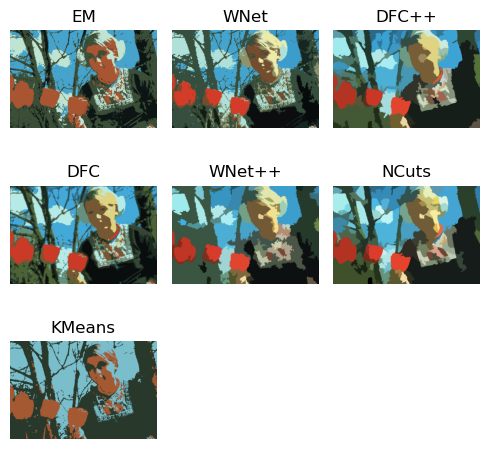

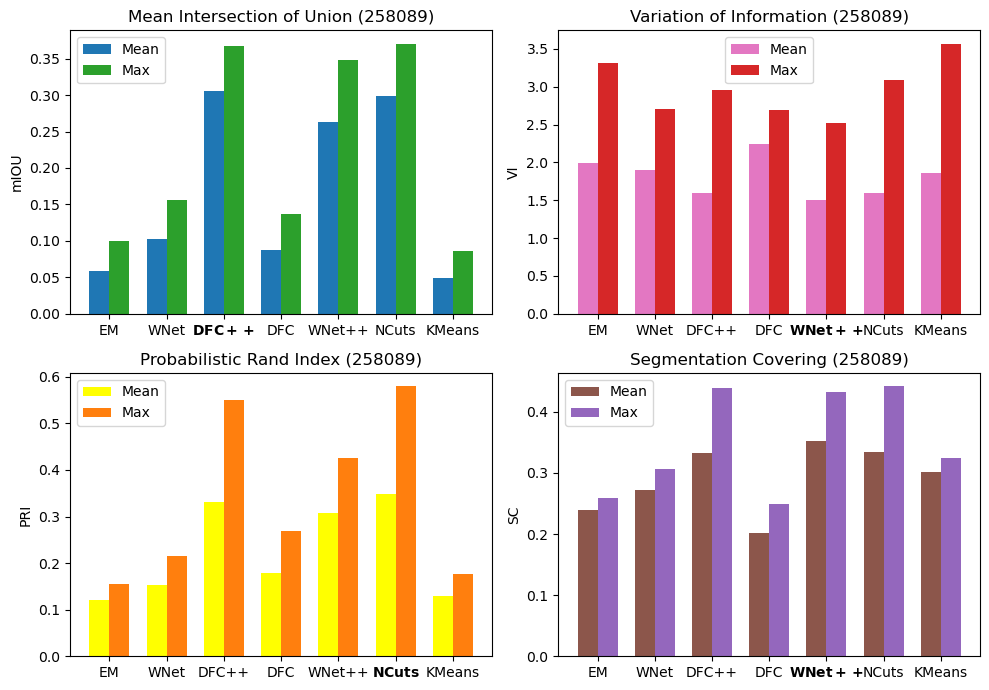

In [304]:
id = 258089

# Load image
original = np.array(Image.open(os.path.join(test_image_dir, f"{id}.jpg")))

segmentation_masks = {path.split("/")[1]: np.loadtxt(path, delimiter=',').astype(int) for path in glob(f'output/*/csv/{id}.csv')}
segmentation_images = {path.split("/")[1]: np.array(Image.open(path)) for path in glob(f'output/*/png/{id}.png')}

# Try stacking with normalized cuts
segmentation_masks["WNet++"] = ensemble_stacking(segmentation_images["WNet"])
segmentation_images["WNet++"] = mask_to_rgb(segmentation_masks["WNet++"], np.array(original))
segmentation_masks["DFC++"] = ensemble_stacking(segmentation_images["DFC"])
segmentation_images["DFC++"] = mask_to_rgb(segmentation_masks["DFC++"], np.array(original))

compare_segmentations(segmentation_images)

metrics = {"mIOU": evaluation.calculate_mIOU, "VI": evaluation.calculate_VI, "PRI": evaluation.calculate_PRI, "SC": evaluation.calculate_SC}
scores = {key: {name: metrics[name](segmentation_masks[key], id) for name in metrics.keys()} for key in segmentation_masks.keys()}

plot_scores_together(scores, single=True)


### Full Evaluation

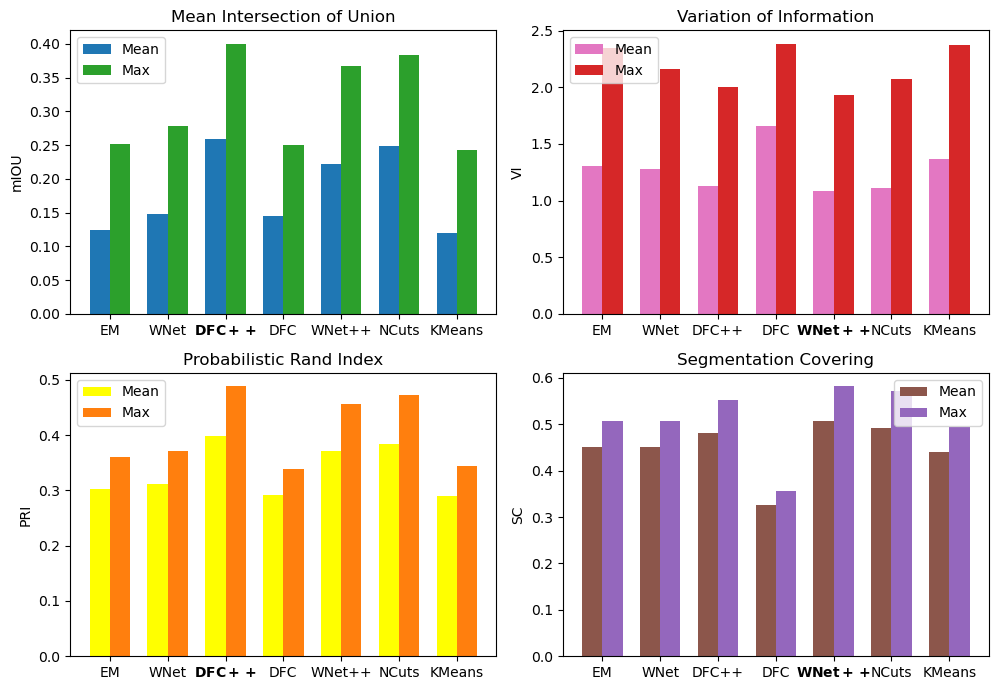

In [305]:
use_precomputed = True
if use_precomputed:
    with open('scores.json', 'r') as f:
        scores = json.load(f)
else:
    methods = [os.path.basename(directory) for directory in glob("output/*")]
    scores = {method: evaluate(f'output/{method}/csv') for method in methods}
    with open('scores.json', 'w') as f:
        json.dump(scores, f)

scores_ = {method: {metric: [scores[method][metric]['mean'],scores[method][metric]['max']] for metric in scores[method].keys()} for method in scores.keys()}

plot_scores_together(scores_)